<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Introduction to Bootstrapping

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Understand the concept of the parametric bootstrap
- Code the parametric bootstrap by hand
- Apply the parametric bootstrap to calculate confidence intervals for statistics
- Understand when the bootstrap is useful
- Practice performing the bootstrap

### Lesson Guide
- [The bootstrapping procedure](#bootstrapping)
- [Coding the nonparametric bootstrap](#code-bootstrap)
- [Comparing bootstrapped confidence intervals to standard](#compare-to-classic)
- [Bootstrapping the median](#bootstrap-median)
- [Theory behind the bootstrap](#theory)
- [Independent practice: confidence intervals of correlations](#independent-practice)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='bootstrapping'></a>

## The bootstrapping procedure

---

Bootstrapping is a powerful resampling method that allows us to estimate the degree of our uncertainty about practically any statistic. The beauty of bootstrapping is that this is done directly from the data without needing to make any assumptions about the distribution of our statistic!

There are many variations on the bootstrap. In this lesson we will cover only the classic **nonparametric bootstrap**. 

**Bootstrapping the confidence interval of a statistic**

Say we wanted to calculate the 95% confidence interval around a statistic such as our sample mean. We could do this using the formula derived based on the CLT, selecting z-scores along the unit Normal distribution that correspond to our confidence level and multiplying them by our standard error.

The nonparametric bootstrap procedure on the other hand does not rely on distributional assumputions of the parameter. Below is pseudocode describing the process:

---

```
for specified number of bootstrap iterations
    create a bootstrap sample by randomly selecting observations with replacement from your sample 
        (same size as sample)
    calculate the statistic of interest on bootstrap sample

calculate lower and upper percentile bounds of bootstrap statistics according to threshold
```

---

Where the 95% confidence threshold in our case would mean we calculate be 2.5th and 97.5th percentile of the bootstrapped sample means.

<a id='code-bootstrap'></a>

### Coding the nonparametric bootstrap by hand: starcraft data

---

Below we will code the nonparametric bootstrap function and calculate the confidence interval for the mean APM from a sample of Starcraft data. 

**Load the Starcraft data:**

In [1]:
starcraft = './datasets/Starcraft_sample.csv'

In [5]:
star = pd.read_csv(starcraft)
print star.shape

(200, 20)


**Extract the APM vector from the dataset:**

In [4]:
apm = star.APM.values

**Plot the distribution of APM with a histogram:**

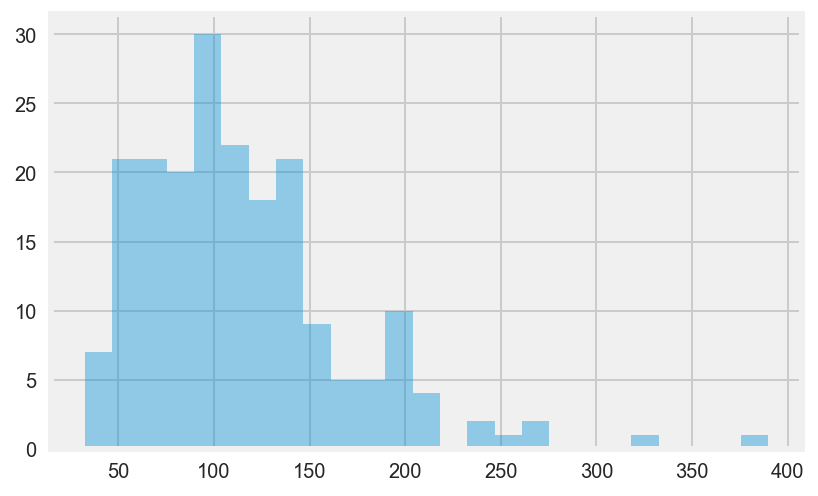

In [5]:
ax = sns.distplot(apm, bins=25, kde=False)

**Write a function for the nonparametric bootstrap procedure.**

The function should take three arguments:
- The sample
- The function to calculate the statistic of interest
- The number of iterations

The function should return a vector of the "bootstrapped" statistics. Refer to the pseudocode above. Remember that the random sampling must be done **with replacement** and the random sample must be the same size as the original sample.

In [6]:
def bootstrap(sample, stat_func, iters=1000):
    boots = []
    for i in range(iters):
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        stat = stat_func(random_sample)
        boots.append(stat)
    return boots

**Using your bootstrapping function with 1000 iterations: calculate the 95% confidence interval for the mean APM.**

Remember that for a 95% confidence interval, we will want to find the 2.5th percentile bootstrapped mean and the 97.5th percentile bootstrapped mean (corresponding to a threshold of 0.05).

The `scipy.stats.scoreatpercentile` function is useful for finding the values at these percentiles.

In [7]:
apm_boot = bootstrap(apm, np.mean)

apm_lower = stats.scoreatpercentile(apm_boot, 2.5)
apm_upper = stats.scoreatpercentile(apm_boot, 97.5)

print apm_lower, np.mean(apm), apm_upper

107.021920275 114.323439 122.02329915


<a id='compare-to-classic'></a>

### Comparing the bootstrapped confidence interval to the classic formula

---

The classic formula for calculating the confidence interval bounds for the sample mean is:

### $$ [\; \bar{x} + z_{\alpha/2}\frac{s}{\sqrt{n}},\; \bar{x} + z_{1-\alpha/2} \frac{s}{\sqrt{n}} ]$$

Where in our case $\alpha = 0.05$. Filling in the appropriate z-scores according to this threshold we have:

### $$ [\; \bar{x} -1.96 \frac{s}{\sqrt{n}},\; \bar{x} + 1.96 \frac{s}{\sqrt{n}} ]$$

**Calculate the confidence interval for the mean APM with the formula above and compare it to our bootstrapped confidence interval.**

In [8]:
std = np.std(apm)
sqrtn = np.sqrt(len(apm))

apm_lower = np.mean(apm) - 1.96*(std/sqrtn)
apm_upper = np.mean(apm) + 1.96*(std/sqrtn)

print apm_lower, np.mean(apm), apm_upper

106.902020672 114.323439 121.744857328


<a id='bootstrap-median'></a>

### A more practical example: bootstrapping the median

---

In the case of estimating the confidence around the sample mean, the bootstrapping procedure is not particularly useful since the sample mean has such nice properties distributional properties. 

The bootstrap becomes much more useful when we need to calculate our uncertaintly around statistics without straightforward formulas or ones with unreasonably strict assumptions. The median is one such statistic. 

**Formula for the sample error of the median (to use for calculating confidence interval around the median):**

There is in fact a formula for the sample error of the median:

### $$ \text{s.e. median} = 1.2533 \cdot \text{s.e. mean} $$

Which is a function of the sample error of the mean and uses a heuristic multiplier 1.2533. Furthermore, it requires these assumptions to work:

1. $N$ is large
2. The sample of measurements are drawn from a normally distributed population

**Check:** What about these assumptions is impractical?

---

The second assumption is strict – many distributions are not normally distributed. Furthermore, what tangible benefit do we get from calculating the median over the mean if we know ahead of time that the population is normally distributed?

The median is much more useful when we suspect a non-normally distributed population.


**Plot the distribution of APM from the Starcraft data with a vertical line indicating the median.**

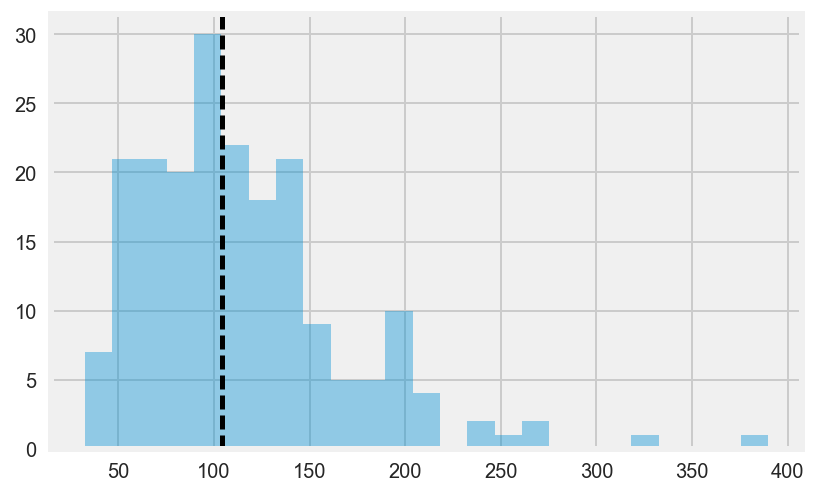

In [9]:
apm_median = np.median(apm)
ax = sns.distplot(apm, bins=25, kde=False)
ax.axvline(apm_median, lw=2.5, ls='dashed', color='black')

#### Calculate a 99% confidence interval for the median for computed with the formula above.

The associated z-score magnitude is 2.576

In [10]:
se_mean = np.std(apm)/np.sqrt(len(apm))
se_median = se_mean*1.2533

apm_med_lower = np.median(apm) - 2.576*se_median
apm_med_upper = np.median(apm) + 2.576*se_median

print apm_med_lower, np.median(apm), apm_med_upper

92.1676821385 104.3922 116.616717862


**Bootstrap the 99% confidence interval for the median with 1000 iterations.**

In [11]:
med_boot = bootstrap(apm, np.median)

med_boot_lower = stats.scoreatpercentile(med_boot, 0.5)
med_boot_upper = stats.scoreatpercentile(med_boot, 99.5)

print med_boot_lower, np.median(apm), med_boot_upper

95.9085 104.3922 116.6199285


**How is the distribution different using the boostrap?**

In [12]:
# The bootstrapped confidence interval is wider on the right-hand side and
# shorter on the left. This mirrors the skew present in the dataset, which
# we can assume is reflected in the overall population as well.
# If the skew is in fact present in the overall population dataset, then
# only the bootstrap confidence interval is appropriate!

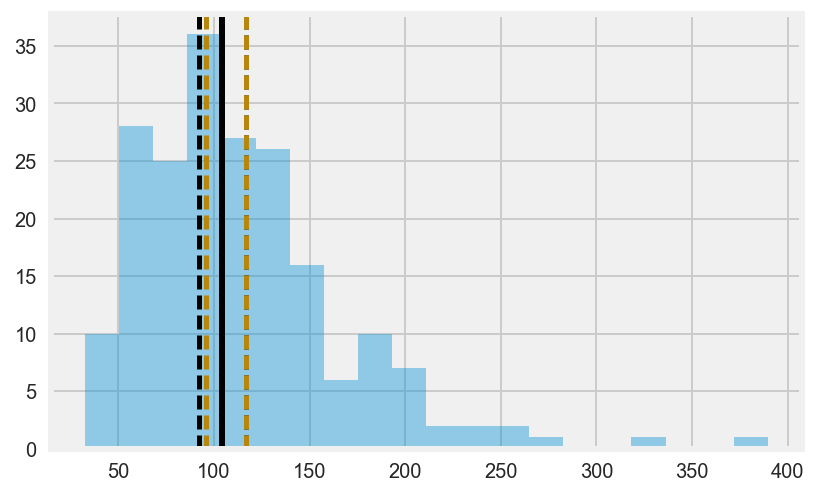

In [13]:
ax = sns.distplot(apm, bins=20, kde=False)
ax.axvline(np.median(apm), lw=3, color='black')
ax.axvline(apm_med_lower, lw=2.5, color='black', ls='dashed')
ax.axvline(apm_med_upper, lw=2.5, color='black', ls='dashed')
ax.axvline(med_boot_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(med_boot_upper, lw=2.5, color='darkgoldenrod', ls='dashed')

<a id='theory'></a>

### Theory behind the bootstrap

---

The idea grounding the boostrap is that inferences we can draw from random samples drawn from our sample can in turn be applied to our inference about the overall population. This is because our random sample of the sample mirrors the fact that our sample is randomly drawn from the population. 

Essentially, bootstrap samples are to our original sample as our original sample is to the overall population.

With a population parameter $\theta$ and sample statistic $\hat{\theta}$ we make an inference about the uncertainty around our estimate of the population parameter.

> We infer the population $\theta$ and uncertainty of the inference from sample $\hat{\theta}_{s}$.

With bootstrapping we mirror this process *to make an inference about the uncertainty around our "estimate" of the sample statistic.*

> Infer uncertainty of our sample statistic $\hat{\theta}_{s}$ from multiple random bootstrap samples drawn from the sample.



<a id='independent-practice'></a>

### Independent practice: bootstrapping the confidence interval of the correlation coefficient

---

Like the median, computing the confidence interval for the pearson correlation coefficient is not straightforward without using the bootstrap procedure. 

**Using the starcraft data or another dataset of your choice, calculate the correlation between two variables you are interested in and then compute the 95% and 99% confidence interval of the correlation with the bootstrap.**

In [14]:
# pull out age
age = star.Age.values

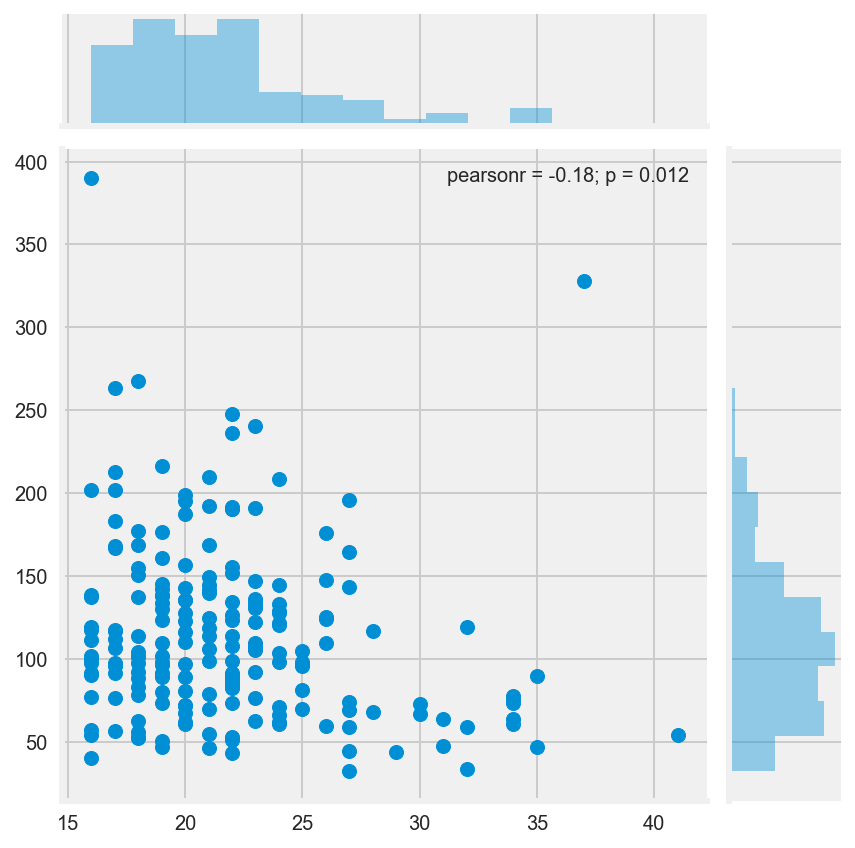

In [15]:
sns.jointplot(age, apm)

In [16]:
# calculate the pearson correlation coefficient between age and apm
r = stats.pearsonr(age, apm)[0]
print r

-0.177824263421


In [17]:
# function to bootstrap the coefficient with 1000 iterations.
# REMEMBER: the x and y need to be paired! I bootstrap the indices
# for the different observations of age, apm pairs.
def bootstrap_r(x, y, iterations=1000):
    boot_r = []
    inds = range(len(x))
    for i in range(iterations):
        boot_inds = np.random.choice(inds, replace=True, size=len(inds))
        x_b = x[boot_inds]
        y_b = y[boot_inds]
        boot_r.append(stats.pearsonr(x_b, y_b)[0])
    return boot_r

In [18]:
r_boots = bootstrap_r(age, apm)

# 95%
lower = stats.scoreatpercentile(r_boots, 2.5)
upper = stats.scoreatpercentile(r_boots, 97.5)

print lower, r, upper

-0.334241999676 -0.177824263421 0.0173352963877


In [19]:
# 99% confidence interval:
lower = stats.scoreatpercentile(r_boots, 0.5)
upper = stats.scoreatpercentile(r_boots, 99.5)

print lower, r, upper

-0.375192901295 -0.177824263421 0.0879661820677


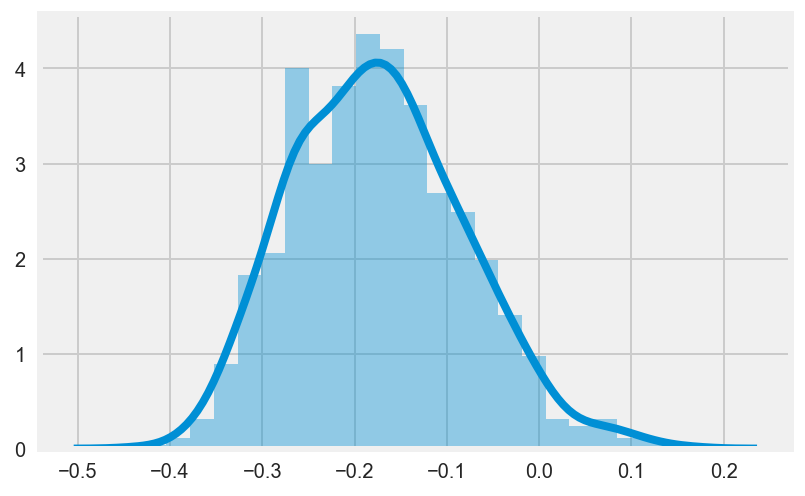

In [20]:
# The distribution of bootstrap pearson r coefficients:
sns.distplot(r_boots)